# Controlling Fairness and Bias in Dynamic Learning-to-Rank

In this Notebook, we show how to run Dynamic Fairness Simulations using our code Base.



In [ ]:
!ls

In [4]:
%load_ext autoreload
%autoreload 2
from data_utils import load_news_items, load_movie_data, load_movie_data_saved, select_companies, select_movies
import numpy as np
from Simulation import assign_groups, Usersampler, simulate, get_numerical_relevances
from Documents import Movie
from plotting import combine_and_plot_ndcg_unfairness
%matplotlib inline
from config import ex
import matplotlib.pyplot as plt
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def get_unfairness(data, G):
    #From Rundata containing Relevance, Exposure and Clicks(Impact), 
    #we compute the the overall unfairness (summed over all pairs of Groups)
    n_methods, iterations = np.shape(data["NDCG"])
    pair_group_combinations = [(a, b) for a in range(len(G)) for b in range(a + 1, len(G))]
    overall_fairness = np.zeros((n_methods, iterations, 4))
    for i in range(n_methods):
        for a, b in pair_group_combinations:   ##[i, :, 0]  [ method_id,iteration, group_id]
            overall_fairness[i, :, 0] += np.abs(
                data["prop"][i, :, a] / data["rel"][i, :, a] - data["prop"][i, :, b] / data["rel"][i, :, b])
            overall_fairness[i, :, 1] += np.abs(
                data["prop"][i, :, a] / data["true_rel"][i, :, a] - data["prop"][i, :, b] / data["true_rel"][i, :, b])
            overall_fairness[i, :, 2] += np.abs(
                data["clicks"][i, :, a] / data["rel"][i, :, a] - data["clicks"][i, :, b] / data["rel"][i, :, b])
            overall_fairness[i, :, 3] += np.abs(
                data["clicks"][i, :, a] / data["true_rel"][i, :, a] - data["clicks"][i, :, b] / data["true_rel"][i,:,b])
            
    return overall_fairness

def plot_unfairness_and_NDCG(ndcg, overall_fairness, ranking_methods, G):
    #Exposure Unfairness
    combine_and_plot_ndcg_unfairness(np.expand_dims(ndcg,axis=1),np.expand_dims(overall_fairness[:, :, 1],axis=1),labels= ranking_methods, selection=np.arange(len(ranking_methods)), name="JupyterNDCG_UnfairExposure.pdf",type = 0 )
    #Impact Unfairness
    combine_and_plot_ndcg_unfairness(np.expand_dims(ndcg,axis=1),np.expand_dims(overall_fairness[:, :, 3],axis=1),labels= ranking_methods, selection=np.arange(len(ranking_methods)), name="JupyterNDCG_UnfairImpact.pdf",type = 1 )


In [3]:
def run_simulation_trial(items, start_popularity, G, ranking_method, user_generator, iterations=3000, DATA_SET = 0,MOVIE_RATING_FILE=""):
    """
    Here, we run our Simulation for A fixed set of items and a single Ranking method.
    
    items: Contain a list of items (Movies or Newsarticles)
    start_popularity: A list of initial Clicks (almost always 0) for all items
    G: A list of |G| lists containing the items in each groups
    ranking_method: The ranking method used ("Pers","IPS","Naive","Fair-I-IPS", "Fair-E-IPS", "Fair-I-Pers", "Fair-E-Pers")
    user_generator: A generator from where we can sample the users (simulated in the News setting, drawn from the database for the Movie setting)
    iterations: The number of users sampled in total
    DATA_SET: Either 0 for the News Experiment or 1 for the Movie Experiment
    MOVIE_RATING_FILE: Needed for the Movie Experiment, the Path to the Rating File (Containing the Groups, Features and Rating Matrix)
    """
    popularity = np.copy(start_popularity)
    # Get theoretical Relevances
    numerical_relevances = get_numerical_relevances(items,DATA_SET, MOVIE_RATING_FILE)
    # Run the Simulation
    iterations, ranking_hist, popularity_hist, final_ranking, users, ideal, mean_relevances, w_pophist, errors, mean_exposure, fairness_hist, p_pophist = \
        simulate(popularity, items, ranking_method=ranking_method, click_model="PBM_log", iterations=iterations, numerical_relevance=numerical_relevances, user_generator=user_generator, DATA_SET=DATA_SET)
    print(iterations, ranking_hist, popularity_hist, final_ranking,\
          users, ideal, mean_relevances, w_pophist, errors, mean_exposure, fairness_hist, p_pophist,\
         "iterations, ranking_hist, popularity_hist, final_ranking,\
          users, ideal, mean_relevances, w_pophist, errors, mean_exposure, fairness_hist, p_pophist")
    return fairness_hist


# News Experiment

For Running the news Experiment, visit https://www.adfontesmedia.com/interactive-media-bias-chart/?v=402f03a963ba, scroll down and download their data as csv. Save this data as:  
"data/InteractiveMediaBiasChart.csv"

The following Code compares a simulation made with the Naive, D-ULTR(Glob), FairCo(Imp) and FairCo(Exp) ranking algorithm.  
First, we load 30 random News Articles, assign them to groups (according to their polarity) and initialize the User generator to simulate a Symmetric distributed (BI_LEFT=0.5) population. 

This is then plugged in the Simulation, and for each ranking method, we obtain the Propensities, Clicks, Estimated_Relevance, True Relevances for each iteration $\tau$ and Group $g$. 

Afterwards, we compute the Disparity from the results, and Plot the NDCG next to the Exposure Unfairness and Impact Unfairness. We can see, that the Controller effectively reduces unfairness.

## Test the data loader

In [150]:
# def load_news_data(seed=18):
seed=18
#MEDIA_SOURCES = ["ABC","AP", "BBC", "Bloomberg", "Breitbart","Buzzfeed","CBS","CNN","Conservative Tribune", "Daily Mail", "Democrazy Now", "Fox News", "Huffington Post", "Intercept", "Life News", "MSNBC", "National Review", "New York Times", "The American Conservative", "The Federalist", "The Guardian", "Washington Post", "WorldNetDaily"]
MEDIA_SOURCES = ["Breitbart", "CNN",
                 "Daily Mail", "Fox News", "Huffington Post", "MSNBC",
                 "New York Times", "The American Conservative", "The Guardian", "WorldNetDaily"]
df = pd.read_csv("data/InteractiveMediaBiasChart.csv",)
df["Group"] = df.Source.astype("category").cat.codes
df["Bias"] /= 40
df["Quality"] /= 62

selector = df["Source"].isin(MEDIA_SOURCES)
df_small = df[selector]
#TODO shorten data
df_tiny = pd.DataFrame(columns=df_small.columns)
#print("LA")
for source in MEDIA_SOURCES:
    one_source = df["Source"] == source
    x = df[one_source].sample(3,random_state=seed)
    #print("Subsample:", x)
    df_tiny = df_tiny.append(x)
df_tiny["Group"] = df_tiny.Source.astype("category").cat.codes
df["Group"] = df.Source.astype("category").cat.codes
items = []
completly_random=True
# return df, df_small, df_tiny
data_full=df
n=30
GROUP_BOUNDARIES = [[-1,-0],[0,1]] #Boundaries for Left and Right
class Item:
    def __init__(self, polarity, quality=1, news_group = None, id=0):
        """
        Creates an Document/article
        Assigns a Group depending on polarity

        """
        self.p = polarity
        self.q = quality
        self.id = id
        if (GROUP_BOUNDARIES[0][0] <= polarity <= GROUP_BOUNDARIES[0][1]):  ## Bias in data is the defined polarity here.\
            ## and here they split it into two groups.
            self.g = 0
        elif (GROUP_BOUNDARIES[1][0] <= polarity <= GROUP_BOUNDARIES[1][1]):
            self.g = 1
        else:
            self.g = 2
        self.news_group = news_group
    def get_features(self):
        tmp = [0] * 3
        tmp[self.g] = 1   ## Some kinds of embedding to construct the feature.
        # return np.asarray([self.p,self.q, self.p**2] + tmp)
        return np.asarray([self.p, self.q] + tmp)  ## So the feature is quality, bias, and groups.
if completly_random:
    for index, row in data_full.sample(n).iterrows():
        items.append(Item(row["Bias"], quality=1, id=index, news_group=row["Group"]))
elif n_left is not None:
    c_left = 0
    for index, row in data_full.sample(frac=1).iterrows():
        if((row["Bias"]<0 and c_left < n_left ) or (row["Bias"]>0 and len(items) < n - (n_left -c_left))):  
            ## will the data unbalanced.
            items.append(Item(row["Bias"], quality=1, id=index, news_group=row["Group"]))
#         if( len(items)>= n):
#             return items
else:
    for index, row in data_tiny.iterrows():
        items.append(Item(row["Bias"],quality=1, id=index, news_group=row["Group"]))
        ## Here  it assume that every docuement have equal quality.

In [82]:
items[0].news_group


9

In [42]:
df_small.columns

Index(['Source', 'Url', 'Bias', 'Quality', 'Group'], dtype='object')

In [43]:
df_tiny  ## it seems that he indeed only use 30 samples.

,Source,Url,Bias,Quality,Group
192,Breitbart,https://www.breitbart.com/national-security/20...,0.41875,0.645161,0
183,Breitbart,https://www.breitbart.com/politics/2019/02/26/...,0.60000,0.616935,0
191,Breitbart,https://www.breitbart.com/crime/2019/04/16/bla...,0.35000,0.673387,0
279,CNN,https://www.cnn.com/2019/02/26/politics/trump-...,-0.10000,0.822581,1
265,CNN,CNN NewsRoom with Poppy Harlow,-0.34175,0.623710,1
297,CNN,Anderson Cooper 360,-0.27500,0.532258,1
403,Daily Mail,https://www.dailymail.co.uk/news/article-69303...,0.31250,0.443548,2
394,Daily Mail,https://www.dailymail.co.uk/news/article-67477...,0.07500,0.661290,2
402,Daily Mail,https://www.dailymail.co.uk/news/article-69304...,0.08750,0.721774,2
591,Fox News,Fox News@Night with Sharon Bream,0.52500,0.508065,3


In [44]:
## THen I will test assign_groups

In [54]:
G = assign_groups(items)
print(len(G[0]))
n_groups = max([i.g for i in items])+1
G = [ [] for i in range(n_groups)]
for i, item in enumerate(items):
    G[item.g].append(i)

19


In [3]:
ranking_methods = ["Naive","IPS","Fair-I-IPS", "Fair-E-IPS"]
items = load_news_items(n=30, n_left=10)
popularity = np.ones(len(items))
G = assign_groups(items)  ## it seems that the n_left can't force to assign the number in each group.

In [147]:
## Then I will test the simulation part.
import data_utils

data_utils.sample_user_base(distribution="bimodal", BI_LEFT=0.5)  ## The BI_LEFT is distribution of left or right user.
##

array([array([0.48399781]), 0.5436033209860318], dtype=object)

In [38]:
data["NDCG"][:,:4]

array([[0.88108584, 0.72060303, 0.64857797, 0.59337303],
       [0.61579696, 0.81098699, 0.55078534, 0.76864715],
       [0.41302048, 0.64556076, 0.46914608, 0.63276409]])

In [5]:
print(overall_fairness.shape)

NameError: name 'overall_fairness' is not defined

In [7]:
ranking_methods = ["Naive","IPS","Fair-I-IPS", "Fair-E-IPS"]
items = load_news_items(n=30, completly_random=True)
popularity = np.ones(len(items))
G = assign_groups(items)
user_generator = Usersampler(DATA_SET=0, BI_LEFT=0.5, MOVIE_RATING_FILE = None)
iterations=2
data = {"prop": np.zeros((len(ranking_methods), iterations, len(G))),
            "clicks": np.zeros((len(ranking_methods), iterations, len(G))), "rel": np.zeros((len(ranking_methods), iterations, len(G))),
            "true_rel": np.zeros((len(ranking_methods), iterations, len(G))), "NDCG": np.zeros((len(ranking_methods), iterations))}

#Run a trial for each Ranking method and add the results to data dict
for i, method in enumerate(ranking_methods):
    data_hist = run_simulation_trial(items, popularity, G, method, user_generator, iterations, DATA_SET=0)
    for key, value in data_hist.items():
        data[key][i] = value

#Get Unfairness based on Collect Data
overall_fairness = get_unfairness(data, G)

plot_unfairness_and_NDCG(data["NDCG"], overall_fairness, ranking_methods, G)


KeyboardInterrupt: 

2 [[29. 28.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
  17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27.  0.]
 [ 9. 29. 28.  1.  2.  3.  4.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16.
  17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27.  0.]] [[1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 2. 1. 1. 1. 2. 1. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1.]] [ 9 29 28  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27  0] [array([array([0.51720215]), 0.17753285994655954], dtype=object), array([array([0.42242734]), 0.3458242777710387], dtype=object)] [ 9 18  8 26 23 21  7  6 17 29  3 25 20  4 10  5  2  1 14 11 12 13 28 15
 16 19 22 24 27  0] [0.  0.5 0.  0.5 0.5 0.  0.5 0.5 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.
 1.  0.  1.  1.  0.  1.  0.5 0.5 1.  0.  0.  0. ] [[1.         1.         1.         1.         1.         1.
  1.         1.         1.         4.58496237 1.         1

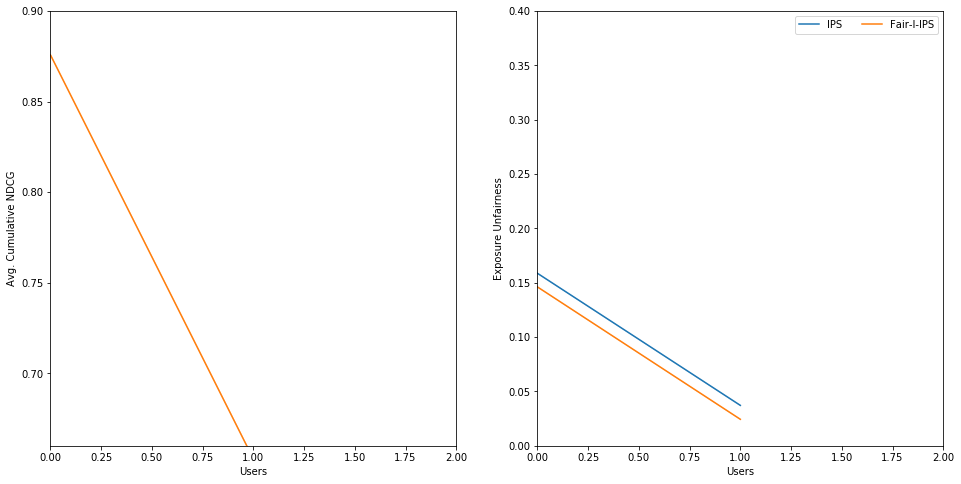

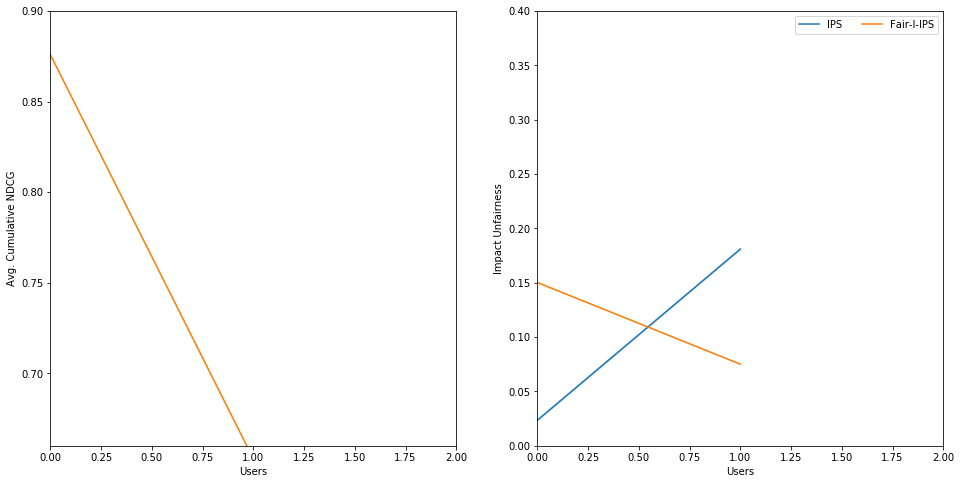

In [8]:
ranking_methods = ["IPS","Fair-I-IPS"]
items = load_news_items(n=30, completly_random=True)
popularity = np.ones(len(items))
G = assign_groups(items)
user_generator = Usersampler(DATA_SET=0, BI_LEFT=0.5, MOVIE_RATING_FILE = None)
iterations=2
data = {"prop": np.zeros((len(ranking_methods), iterations, len(G))),
            "clicks": np.zeros((len(ranking_methods), iterations, len(G))), "rel": np.zeros((len(ranking_methods), iterations, len(G))),
            "true_rel": np.zeros((len(ranking_methods), iterations, len(G))), "NDCG": np.zeros((len(ranking_methods), iterations))}

#Run a trial for each Ranking method and add the results to data dict
for i, method in enumerate(ranking_methods):
    data_hist = run_simulation_trial(items, popularity, G, method, user_generator, iterations, DATA_SET=0)
    for key, value in data_hist.items():
        data[key][i] = value

#Get Unfairness based on Collect Data
overall_fairness = get_unfairness(data, G)

plot_unfairness_and_NDCG(data["NDCG"], overall_fairness, ranking_methods, G)


In [9]:
data

{'prop': array([[[ 6.27643456,  2.88514648],
         [11.96704631,  6.35611578]],
 
        [[ 6.27643456,  2.88514648],
         [11.96947844,  6.35368365]]]),
 'clicks': array([[[20., 11.],
         [21., 13.]],
 
        [[23., 12.],
         [23., 12.]]]),
 'rel': array([[[20.        , 13.58496284],
         [22.80735397, 18.04439545]],
 
        [[28.04439545, 16.71424484],
         [28.04439545, 16.71424484]]]),
 'true_rel': array([[[ 6.7595 ,  3.74768],
         [13.519  ,  7.49536]],
 
        [[ 6.78422,  3.70366],
         [13.56844,  7.40732]]]),
 'NDCG': array([[0.4544915 , 0.80070092],
        [0.87570297, 0.42976763]])}

# Replicate FIgure1

0 Naive i,method
1 IPS i,method
2 Fair-I-IPS i,method


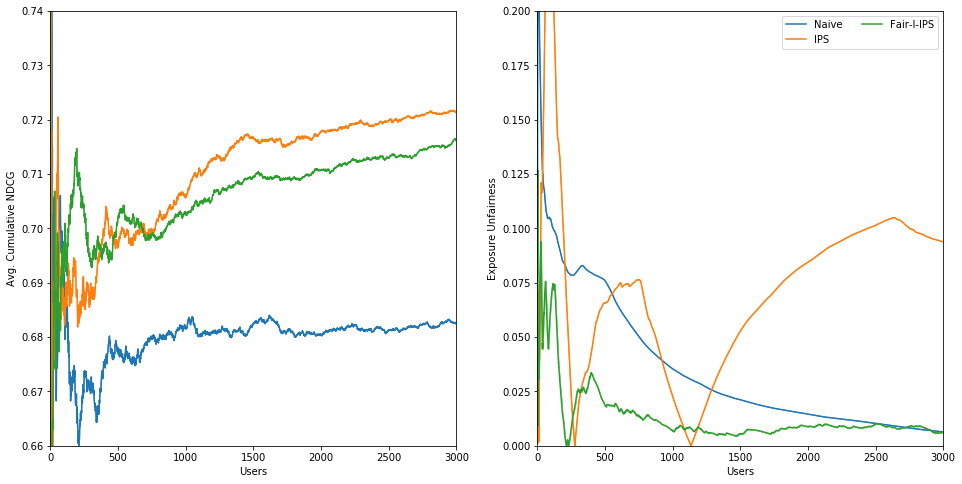

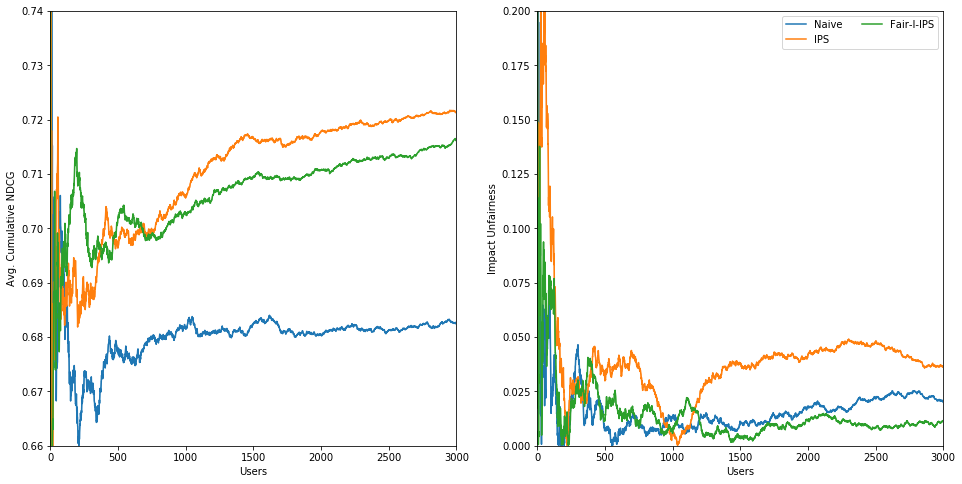

In [44]:
ranking_methods = ["Naive","IPS","Fair-I-IPS"]
items = load_news_items(n=30, completly_random=True)
popularity = np.ones(len(items))
G = assign_groups(items)
user_generator = Usersampler(DATA_SET=0, BI_LEFT=0.5, MOVIE_RATING_FILE = None)
iterations=3000
data = {"prop": np.zeros((len(ranking_methods), iterations, len(G))),
            "clicks": np.zeros((len(ranking_methods), iterations, len(G))), "rel": np.zeros((len(ranking_methods), iterations, len(G))),
            "true_rel": np.zeros((len(ranking_methods), iterations, len(G))), "NDCG": np.zeros((len(ranking_methods), iterations))}

#Run a trial for each Ranking method and add the results to data dict
for i, method in enumerate(ranking_methods):
    print(i,method,"i,method")
    data_hist = run_simulation_trial(items, popularity, G, method, user_generator, iterations, DATA_SET=0)
    for key, value in data_hist.items():
        data[key][i] = value

#Get Unfairness based on Collect Data
overall_fairness = get_unfairness(data, G)

plot_unfairness_and_NDCG(data["NDCG"], overall_fairness, ranking_methods, G)


In [54]:
!python main.py with 'EXPERIMENT=1' 'PLOT_PREFIX="plots/EXP1/"' 'trials=100'

Using TensorFlow backend.
WARNING - Dynamic Fairness - No observers have been added to this run
INFO - Dynamic Fairness - Running command '__main__'
INFO - Dynamic Fairness - Started
1 data/movie_data_binary_latent_5Comp_trial0.npy plots/EXP1/ 100 3000 EXPERIMENT, MOVIE_RATING_FILE, PLOT_PREFIX, trials, iterations
trails 0 method Naive
trails 1 method Naive
trails 2 method Naive
trails 3 method Naive
trails 4 method Naive
trails 5 method Naive
trails 6 method Naive
trails 7 method Naive
trails 8 method Naive
trails 9 method Naive
trails 10 method Naive
trails 11 method Naive
trails 12 method Naive
trails 13 method Naive
trails 14 method Naive
trails 15 method Naive
trails 16 method Naive
trails 17 method Naive
trails 18 method Naive
trails 19 method Naive
trails 20 method Naive
trails 21 method Naive
trails 22 method Naive
trails 23 method Naive
trails 24 method Naive
trails 25 method Naive
trails 26 method Naive
trails 27 method Naive
trails 28 method Naive
trails 29 method Naive
trai

In [ ]:
! python main.py with 'EXPERIMENT=3' 'PLOT_PREFIX="plots/EXP3/"' 'trials=10' 

Using TensorFlow backend.
WARNING - Dynamic Fairness - No observers have been added to this run
INFO - Dynamic Fairness - Running command '__main__'
INFO - Dynamic Fairness - Started
3 data/movie_data_binary_latent_5Comp_trial0.npy plots/EXP3/ 10 3000 EXPERIMENT, MOVIE_RATING_FILE, PLOT_PREFIX, trials, iterations
Progress 0.00%
Progress 2.78%
Progress 5.56%
Progress 8.33%
Progress 11.11%
Progress 13.89%
Progress 16.67%
Progress 19.44%
Progress 22.22%
Progress 25.00%
Progress 27.78%


In [79]:
import multiprocessing

multiprocessing.cpu_count()

40

In [6]:
from plotting import *

(3000,) (3000,) 2274.6533945256606 2257.0517109270686
(3000,) (3000,) 2327.0052793117543 2289.08244941293
(3000,) (3000,) 2552.5211097911424 2444.336176793687
(3000,) (3000,) 2656.113071666725 2569.5482454310095


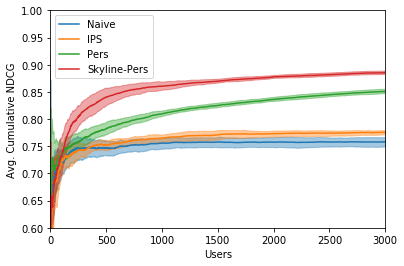

In [15]:
all_stats=np.load("plots/EXP7/Fairness_Data.npy",allow_pickle=True)
run_data=all_stats
PLOT_PREFIX="plots/EXP7/"
methods=["Naive", "IPS", "Pers", "Skyline-Pers"]
click_models=["PBM_log"]
labels = [b for a in click_models for b in methods]
for i, nd in enumerate(run_data):
    plot_ndcg(np.mean(nd["NDCG"], axis=0), label=labels[i], plot=False, window_size=100, std=nd["NDCG"])
plt.legend()
ax = plt.gca()
plt.savefig(PLOT_PREFIX + "NDCG.pdf", bbox_inches="tight", dpi=800)
plt.show()
plt.close("all")

(3000,) (3000,) 2310.321428809695 2284.363360370285
(3000,) (3000,) 2333.9048032098235 2300.3296822696
(3000,) (3000,) 2571.155964847398 2454.764980037642
(3000,) (3000,) 2259.7370403094274 2229.4708614765486


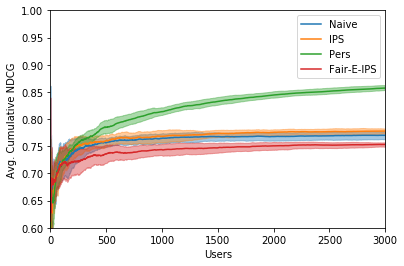

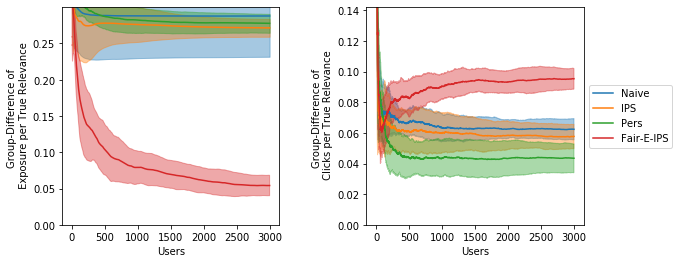

In [22]:
all_stats=np.load("plots/EXP8/Fairness_Data.npy",allow_pickle=True)
run_data=all_stats
PLOT_PREFIX="plots/EXP8/"
methods=["Naive", "IPS", "Pers", "Fair-E-IPS"]
click_models=["PBM_log"]
plt.figure("NDCG")
# plt.title("Average NDCG")
# labels = [ a + "\n" + b for a in click_models for b in methods]
labels = [b for a in click_models for b in methods]
trials=10
iterations=3000
overall_fairness = np.zeros((len(click_models) * len(methods), trials, iterations, 4))
for i, nd in enumerate(run_data):
    plot_ndcg(np.mean(nd["NDCG"], axis=0), label=labels[i], plot=False, window_size=100, std=nd["NDCG"])
plt.legend()
ax = plt.gca()
plt.savefig(PLOT_PREFIX + "NDCG.pdf", bbox_inches="tight", dpi=800)
plt.show()
plt.close("all")
G=[1,5,2,3,4]
pair_group_combinations = [(a, b) for a in range(len(G)) for b in range(a + 1, len(G))]
# Plot Clicks
# plot_click_bar_plot(frac_c, labels, save=True)

# if True:
#     plt.close("all")
#     # Plot Convergence of Relevance
#     for y in rel_diff:
#         p = plt.plot(np.arange(len(y[0])), y[0], label=y[1])
#         color = p[-1].get_color()
#         plt.fill_between(np.arange(len(y[0])), y[0] - y[2],
#                          y[0] + y[2], alpha=0.4, color=color)

#     plt.legend(loc="best")
#     plt.axis([0, len(y[0]), 0, 0.3])
#     # plt.ylabel("Avg diff between \n True & Estimated Relevance  ")
#     plt.ylabel(r'average $|\hat{R}(d) - {R}(d)|$')

#     plt.xlabel("Users")
#     plt.savefig(PLOT_PREFIX + "Relevance_convergence.pdf", bbox_inches="tight")
#     plt.show()

# plot_neural_error(nn_errors, [b for a in click_models for b in methods if "Pers" in b])
# Plot Unfairness over time between different models

for i, data in enumerate(run_data):

    for a, b in pair_group_combinations:
        overall_fairness[i, :, :, 0] += np.abs(
            data["prop"][:, :, a] / data["rel"][:, :, a] - data["prop"][:, :, b] / data["rel"][:, :, b])
        overall_fairness[i, :, :, 1] += np.abs(
            data["prop"][:, :, a] / data["true_rel"][:, :, a] - data["prop"][:, :, b] / data["true_rel"][:, :, b])
        overall_fairness[i, :, :, 2] += np.abs(
            data["clicks"][:, :, a] / data["rel"][:, :, a] - data["clicks"][:, :, b] / data["rel"][:, :, b])
        overall_fairness[i, :, :, 3] += np.abs(
            data["clicks"][:, :, a] / data["true_rel"][:, :, a] - data["clicks"][:, :, b] / data["true_rel"][:, :,
                                                                                            b])

overall_fairness /= len(pair_group_combinations)
plot_unfairness_over_time(overall_fairness, click_models, methods, True)

ndcg_full = []
for data in run_data:
    ndcg_full.append(data["NDCG"])
plt.close('all')
combine_and_plot_ndcg_unfairness(ndcg_full,overall_fairness[:, :, :, 1],labels= labels, selection=np.arange(len(run_data)), name=PLOT_PREFIX + "NDCG_UnfairExposure.pdf",type = 0 )
combine_and_plot_ndcg_unfairness(ndcg_full,overall_fairness[:, :, :, 3],labels= labels, selection=np.arange(len(run_data)), name=PLOT_PREFIX + "NDCG_UnfairImpact.pdf",type = 1 )

In [87]:
fraction = [i / 30. for i in range(1,16)]
methods = ["Naive", "D-ULTR(Glob)", "FairCo(Imp)"]
prefix="plots/EXP5/"
plot_with_errorbar(fraction, all_stats, methods, prefix + "different_groupsize.pdf", "Proportion of Left-Leaning Items")
plot_with_errorbar(fraction, all_stats, methods, prefix + "different_groupsizeExposure.pdf", "Proportion of Left-Leaning Items", impact=False)

In [55]:
def get_unfairness(clicks, rel, G, error=False):
    """
    Get the Unfairess
    Input Clicks (Cum_Exposure for Exposure Unfairness, Clicks for Impact Unfairness)
    If Error, we return the difference to the best treated group,
    Otherwise just return the Exposure/Impact per Relevance
    """
    n = len(clicks)
    group_clicks = [sum(clicks[G[i]]) for i in range(len(G))]
    group_rel = [max(0.0001, sum(rel[G[i]])) for i in range(len(G))]
    group_fairness = [group_clicks[i] / group_rel[i] for i in range(len(G))]
    if (error):
        best = np.max(group_fairness)
        fairness_error = np.zeros(n)
        for i in range(len(G)):
            fairness_error[G[i]] = best - group_fairness[i]
        return fairness_error
    else:
        return group_fairness  ## From here, we know that all fairness additional score are positive,\
    #which means we try to put those which dont get enough propensity additional propensity to make them rank
    # a little bit higher.

In [70]:
clicks=np.array([2,1,3,4,2])
rel=np.array([0.1,0.1,0.3,0.2,.5])
G=np.array([[1,0],[4],[2,3]])
group_fairness=get_unfairness(clicks, rel, G, error=True)

In [71]:
group_fairness

array([ 0.,  0.,  1.,  1., 11.])

In [63]:
len(clicks)

4

In [62]:
sum(clicks[G[0]])

3

(3000,) (3000,) 2560.6684134367792 2446.3575801319466
(3000,) (3000,) 2559.807263663439 2441.585620242763
(3000,) (3000,) 2492.1829654975354 2396.3423445978583


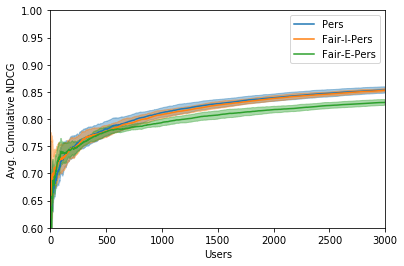

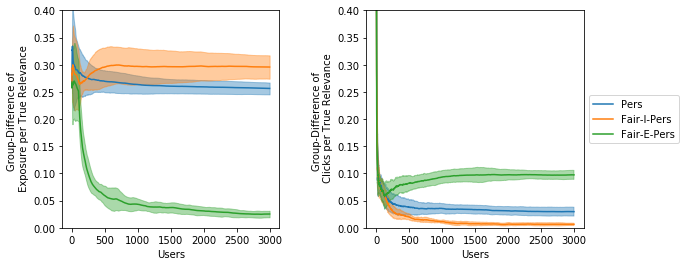

In [33]:
all_stats=np.load("plots/EXP10/Fairness_Data.npy",allow_pickle=True)
run_data=all_stats
PLOT_PREFIX="plots/EXP10/"
methods=["Pers", "Fair-I-Pers",  "Fair-E-Pers"]
click_models=["PBM_log"]
plt.figure("NDCG")
# plt.title("Average NDCG")
# labels = [ a + "\n" + b for a in click_models for b in methods]
labels = [b for a in click_models for b in methods]
trials=10
iterations=3000
overall_fairness = np.zeros((len(click_models) * len(methods), trials, iterations, 4))
for i, nd in enumerate(run_data):
    plot_ndcg(np.mean(nd["NDCG"], axis=0), label=labels[i], plot=False, window_size=100, std=nd["NDCG"])
plt.legend()
ax = plt.gca()
plt.savefig(PLOT_PREFIX + "NDCG.pdf", bbox_inches="tight", dpi=800)
plt.show()
plt.close("all")
G=[1,5,2,3,4]
pair_group_combinations = [(a, b) for a in range(len(G)) for b in range(a + 1, len(G))]
# Plot Clicks
# plot_click_bar_plot(frac_c, labels, save=True)

# if True:
#     plt.close("all")
#     # Plot Convergence of Relevance
#     for y in rel_diff:
#         p = plt.plot(np.arange(len(y[0])), y[0], label=y[1])
#         color = p[-1].get_color()
#         plt.fill_between(np.arange(len(y[0])), y[0] - y[2],
#                          y[0] + y[2], alpha=0.4, color=color)

#     plt.legend(loc="best")
#     plt.axis([0, len(y[0]), 0, 0.3])
#     # plt.ylabel("Avg diff between \n True & Estimated Relevance  ")
#     plt.ylabel(r'average $|\hat{R}(d) - {R}(d)|$')

#     plt.xlabel("Users")
#     plt.savefig(PLOT_PREFIX + "Relevance_convergence.pdf", bbox_inches="tight")
#     plt.show()

# plot_neural_error(nn_errors, [b for a in click_models for b in methods if "Pers" in b])
# Plot Unfairness over time between different models

for i, data in enumerate(run_data):

    for a, b in pair_group_combinations:
        overall_fairness[i, :, :, 0] += np.abs(
            data["prop"][:, :, a] / data["rel"][:, :, a] - data["prop"][:, :, b] / data["rel"][:, :, b])
        overall_fairness[i, :, :, 1] += np.abs(
            data["prop"][:, :, a] / data["true_rel"][:, :, a] - data["prop"][:, :, b] / data["true_rel"][:, :, b])
        overall_fairness[i, :, :, 2] += np.abs(
            data["clicks"][:, :, a] / data["rel"][:, :, a] - data["clicks"][:, :, b] / data["rel"][:, :, b])
        overall_fairness[i, :, :, 3] += np.abs(
            data["clicks"][:, :, a] / data["true_rel"][:, :, a] - data["clicks"][:, :, b] / data["true_rel"][:, :,
                                                                                            b])

overall_fairness /= len(pair_group_combinations)
plot_unfairness_over_time(overall_fairness, click_models, methods, True, PLOT_PREFIX)

ndcg_full = []
for data in run_data:
    ndcg_full.append(data["NDCG"])
plt.close('all')
combine_and_plot_ndcg_unfairness(ndcg_full,overall_fairness[:, :, :, 1],labels= labels, selection=np.arange(len(run_data)), name=PLOT_PREFIX + "NDCG_UnfairExposure.pdf",type = 0 )
combine_and_plot_ndcg_unfairness(ndcg_full,overall_fairness[:, :, :, 3],labels= labels, selection=np.arange(len(run_data)), name=PLOT_PREFIX + "NDCG_UnfairImpact.pdf",type = 1 )

In [108]:
Items=load_news_items(n = 5,n_left=3)

0.45833333325 34
-0.5582499999999999 19
0.1 98
-0.36675 85
-0.08325 53


In [ ]:
from Documents import Item, Movie

# Movie Experiment

For running the movie Experiment, you need to ML-20M Dataset in "data/ratings.csv" (https://grouplens.org/datasets/movielens/20m/) 
and the Movie Metadata in "data/movies_metadata.csv" ( orginally obtained from https://www.kaggle.com/rounakbanik/the-movies-dataset?select=movies_metadata.csv)

In [10]:
! cp data/ml-20m/ratings.csv data/

In [170]:
meta_data["production_companies"][1]

"[{'name': 'TriStar Pictures', 'id': 559}, {'name': 'Teitler Film', 'id': 2550}, {'name': 'Interscope Communications', 'id': 10201}]"

In [4]:
def define_genre(meta_data):

    #Defining Genres
    #Generates a List of Lists of Movies in each Genre
    genres = []
    movie_g_id = []
    for ge in meta_data["genres"]:
        movie_g_id.append([])
        for temp in eval(ge):
            movie_g_id[-1].append(temp["id"])
            if temp not in genres:
                genres.append(temp)
    g_idx = [g["id"] for g in genres]
    #Modify the Genres according to the Group Id.
    meta_data["genres"] = meta_data["genres"].map(lambda xx: [xxx["id"] for xxx in eval(xx)])
    return meta_data, g_idx


In [180]:
meta_data = pd.read_csv("data/movies_metadata.csv")[["production_companies", "id", "genres"]]
#Delete Movies with Date as ID
meta_data = meta_data.drop([19730, 29503, 35587]) # No int id

#Get Genres
meta_data, g_idx = define_genre(meta_data)
meta_data, comp_dict = select_companies(meta_data)

In [187]:
comp_dict

{"[{'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]": 0,
 "[{'name': 'Warner Bros.', 'id': 6194}]": 1,
 "[{'name': 'Paramount Pictures', 'id': 4}]": 2,
 "[{'name': 'Twentieth Century Fox Film Corporation', 'id': 306}]": 3,
 "[{'name': 'Columbia Pictures Corporation', 'id': 441}]": 4,
 "[{'name': 'Columbia Pictures', 'id': 5}]": 4}

In [188]:
meta_data

,production_companies,id,genres
3,[{'name': 'Twentieth Century Fox Film Corporat...,31357,"[35, 18, 10749]"
19,"[{'name': 'Columbia Pictures', 'id': 5}]",11517,"[28, 35, 80]"
38,"[{'name': 'Paramount Pictures', 'id': 4}]",9603,"[35, 18, 10749]"
60,"[{'name': 'Paramount Pictures', 'id': 4}]",17182,"[18, 53]"
78,"[{'name': 'Columbia Pictures Corporation', 'id...",9623,"[18, 53]"
...,...,...,...
44711,"[{'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8...",14570,"[28, 18]"
44943,"[{'name': 'Paramount Pictures', 'id': 4}]",42616,[37]
44955,"[{'name': 'Paramount Pictures', 'id': 4}]",204997,"[80, 9648]"
45237,"[{'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8...",69483,"[35, 10749]"


In [171]:
ratings_full = pd.read_csv("data/ratings.csv")

In [173]:
ratings_full[:1]

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027


In [166]:
meta_data

,production_companies,id,genres
0,"[{'name': 'Pixar Animation Studios', 'id': 3}]",862,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",8844,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",15602,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,[{'name': 'Twentieth Century Fox Film Corporat...,31357,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,"[{'name': 'Sandollar Productions', 'id': 5842}...",11862,"[{'id': 35, 'name': 'Comedy'}]"
...,...,...,...
45461,[],439050,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n..."
45462,"[{'name': 'Sine Olivia', 'id': 19653}]",111109,"[{'id': 18, 'name': 'Drama'}]"
45463,"[{'name': 'American World Pictures', 'id': 6165}]",67758,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam..."
45464,"[{'name': 'Yermoliev', 'id': 88753}]",227506,[]


In [189]:
meta_data

,production_companies,id,genres
3,[{'name': 'Twentieth Century Fox Film Corporat...,31357,"[35, 18, 10749]"
19,"[{'name': 'Columbia Pictures', 'id': 5}]",11517,"[28, 35, 80]"
38,"[{'name': 'Paramount Pictures', 'id': 4}]",9603,"[35, 18, 10749]"
60,"[{'name': 'Paramount Pictures', 'id': 4}]",17182,"[18, 53]"
78,"[{'name': 'Columbia Pictures Corporation', 'id...",9623,"[18, 53]"
...,...,...,...
44711,"[{'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8...",14570,"[28, 18]"
44943,"[{'name': 'Paramount Pictures', 'id': 4}]",42616,[37]
44955,"[{'name': 'Paramount Pictures', 'id': 4}]",204997,"[80, 9648]"
45237,"[{'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8...",69483,"[35, 10749]"


In [190]:
n_movies

NameError: name 'n_movies' is not defined

In [196]:
ratings

,userId,movieId,rating,timestamp
1027,11,828,4.0,1230784021
1072,11,1676,4.5,1230789404
1321,11,31555,5.0,1230788988
1457,11,69526,5.0,1251170492
5520,54,830,2.0,974841243
...,...,...,...,...
19997803,138474,502,4.0,966406467
19997929,138474,1380,5.0,966398502
19997936,138474,1405,5.0,966371791
19997976,138474,1676,4.0,966403795


In [197]:
meta_data

,production_companies,id,genres
88,"[{'name': 'Paramount Pictures', 'id': 4}]",2086,"[80, 18, 53]"
255,[{'name': 'Twentieth Century Fox Film Corporat...,6071,"[28, 80, 18, 53]"
324,"[{'name': 'Paramount Pictures', 'id': 4}]",193,"[878, 28, 12, 53]"
332,"[{'name': 'Paramount Pictures', 'id': 4}]",1587,"[10749, 18]"
619,"[{'name': 'Paramount Pictures', 'id': 4}]",1592,"[80, 18, 9648, 53]"
...,...,...,...
29390,"[{'name': 'Warner Bros.', 'id': 6194}]",45679,[80]
33107,"[{'name': 'Paramount Pictures', 'id': 4}]",27456,[18]
35677,[{'name': 'Twentieth Century Fox Film Corporat...,4459,[53]
38093,"[{'name': 'Columbia Pictures Corporation', 'id...",3941,[35]


In [201]:
ranking_matrix[1]

array([0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 4., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [203]:
features_matrix_factorization.shape

(10000, 50)

In [206]:
len(movie_idx_to_id)

100

In [208]:
ranking_matrix.shape

(10000, 100)

In [209]:
full_matrix[1]

array([2.5474868 , 3.33037215, 2.0816394 , 4.        , 2.33053093,
       2.21499911, 2.42441022, 3.44110628, 2.16676926, 2.28757039,
       2.81556896, 2.51921715, 2.49108758, 2.47644992, 1.51216838,
       1.71822466, 1.94950972, 2.        , 2.64620366, 1.68518516,
       2.43865606, 2.74779492, 2.6634495 , 1.94806658, 2.8909952 ,
       1.73099226, 2.25485662, 2.96933665, 1.79393056, 2.28199962,
       1.60391945, 1.74912287, 2.56875768, 2.77524168, 1.78290178,
       2.3357811 , 3.38291354, 2.39095361, 2.07781059, 2.39410901,
       1.84556302, 2.11563531, 1.21530791, 0.74360977, 2.16478041,
       0.19831021, 2.34763527, 2.        , 2.89598764, 2.32693003,
       2.68181761, 2.19378237, 1.69243045, 1.1438071 , 1.63241073,
       1.71687274, 2.33248545, 2.        , 2.87855659, 3.08127407,
       2.61900083, 1.96753435, 2.66371022, 2.46278833, 1.14515536,
       2.42398009, 2.10825255, 3.06794519, 2.62705236, 4.        ,
       2.93262605, 2.43612857, 2.21263492, 1.56043916, 1.42501

In [7]:
from data_utils import *
meta_data = pd.read_csv("data/movies_metadata.csv")[["production_companies", "id", "genres"]]
#Delete Movies with Date as ID
meta_data = meta_data.drop([19730, 29503, 35587]) # No int id
n_movies, n_user, n_company=100,10000,5
movie_features="factorization"
movie_ranking_sample_file = "Jupyter-Binarized"
#Get Genres
meta_data, g_idx = define_genre(meta_data)

#Filter by Production Company to obtain 5 Groups
meta_data, comp_dict = select_companies(meta_data)

#Y = meta data from selected Companies

#Load Ratings
ratings_full = pd.read_csv("data/ratings.csv")
ratings = ratings_full[ratings_full["movieId"].isin(meta_data["id"])]
ratings, meta_data = select_movies(ratings, meta_data, n_movies, n_user)

#Complete Ranking Matrix
ranking_matrix = get_ranking_matrix_incomplete(ratings, meta_data, n_user)
full_matrix, features_matrix_factorization, movie_idx_to_id = get_matrix_factorization(ratings, meta_data, n_user, n_movies)
#Add the real rating for already rated movies
full_matrix[np.nonzero(ranking_matrix)] = ranking_matrix[np.nonzero(ranking_matrix)] ## fill the rating matrix bu estimation.

if movie_features == "factorization":
    user_features = features_matrix_factorization
else:
    user_features = get_user_features_genre(ratings,ratings_full, meta_data, n_user,g_idx)

#Generate Probability Matrix
#ranking_matrix = np.clip((full_matrix - 1) / 4, a_min=0, a_max=1)
prob_matrix = sigmoid(full_matrix) 

groups = [comp_dict[meta_data[meta_data["id"].isin([x])]["production_companies"].to_list()[0]] for x in
          movie_idx_to_id]

po = ratings["userId"].value_counts()
po2 = ratings["movieId"].value_counts()
print("Number of Users", len(po.index), "Number of Movies", len(po2.index))
print("the Dataset before completion is", len(ratings) / float(n_user*n_movies), " filled")
print("The most rated movie has {} votes, the least {} votes; mean {}".format(po2.max(), po2.min(), po2.mean()))
print("The most rating user rated {} movies, the least {} movies; mean {}".format(po.max(), po.min(), po.mean()))

#The list of groups contains all movies
assert(np.shape(groups) == (n_movies,))
if movie_ranking_sample_file:
    for i in range(10):
        random_matrix = np.random.rand(n_user, n_movies)
        np.save(movie_ranking_sample_file+"{}.npy".format(i), [np.asarray(prob_matrix > random_matrix, dtype=np.float16),user_features, groups])

(10000, 100)
MSE: 0.3440
MSE:  0.34398830795625596
RMSE: 0.5865
RMSE:  0.5865051644753488
Means:  -0.00867196424132933 -0.042481227735741166
Feature STD: 0.14691709690075286 0.5126080547197872
Full Matrix Shape (10000, 100) rankinG_shape (10000, 100)
Number of Users 10000 Number of Movies 100
the Dataset before completion is 0.047847  filled
The most rated movie has 5921 votes, the least 3 votes; mean 478.47
The most rating user rated 52 movies, the least 3 movies; mean 4.7847


After preprocessing the dataset, the following Code compares a simulation made with the Naive, D-ULTR(Pers), FairCo(Imp)(Pers) and FairCo(Exp)(Pers) ranking algorithm. 

Looking at the results, we can see that the Personalized models achieve much higher NDCG than the Naive algorithm. We can also see, that the Controller effectively reduces Unfairness. However, it is important to optimize the correct fairness metric, as a Controller optimizing for Exposure produces more unfair results in terms of impact and vice versa.

(10000, 100)
trial99, loss: [-0.030394423753023148, -0.0598018541932106]
trial99, loss: [-0.03285740315914154, -0.06074465811252594]
trial99, loss: [-0.034471265971660614, -0.06350937485694885]


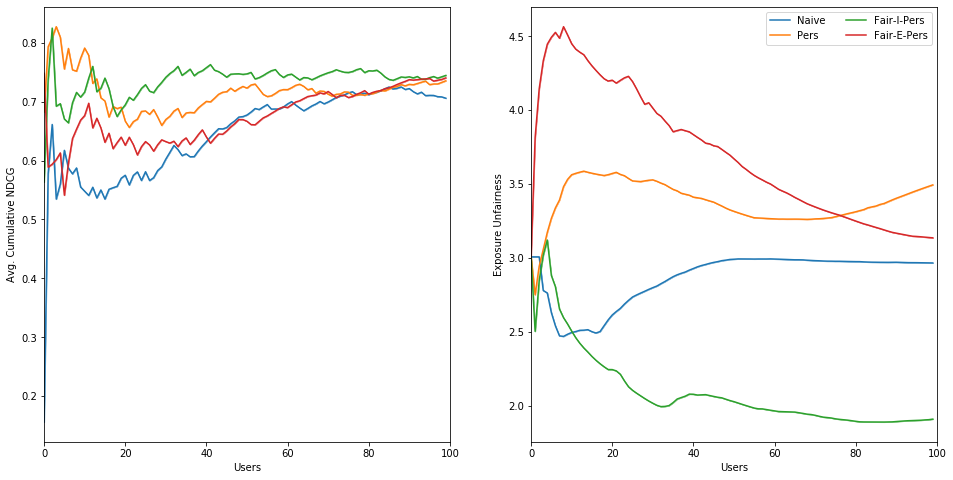

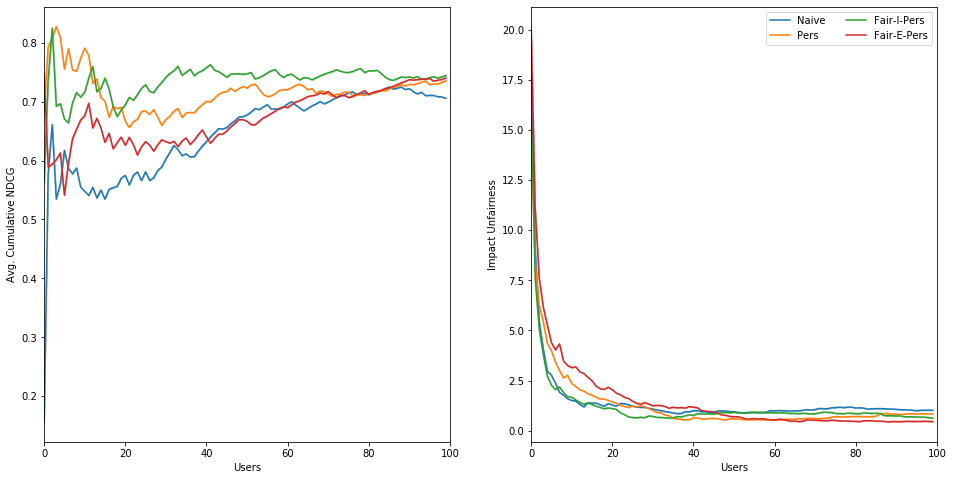

In [13]:
ranking_methods = ["Naive","Pers","Fair-I-Pers", "Fair-E-Pers"]
iterations = 100
_, _, groups = load_movie_data_saved(MOVIE_RATING_FILE)
items = []
for i, g in enumerate(groups):
    items.append(Movie(i, g))
popularity = np.ones(len(items))
G = assign_groups(items)

#The User Generator loads the relevance Matrix from File
user_generator = Usersampler(DATA_SET=1, BI_LEFT=0.5, MOVIE_RATING_FILE = MOVIE_RATING_FILE)

data = {"prop": np.zeros((len(ranking_methods), iterations, len(G))),
            "clicks": np.zeros((len(ranking_methods), iterations, len(G))), "rel": np.zeros((len(ranking_methods), iterations, len(G))),
            "true_rel": np.zeros((len(ranking_methods), iterations, len(G))), "NDCG": np.zeros((len(ranking_methods), iterations))}

#Run trial for each Ranking method and add to data dict
for i, method in enumerate(ranking_methods):
    data_hist = run_simulation_trial(items, popularity, G, method, user_generator, iterations, DATA_SET=1, MOVIE_RATING_FILE=MOVIE_RATING_FILE)
    for key, value in data_hist.items():
        data[key][i] = value

#Get Unfairness based on Collect Data
overall_fairness = get_unfairness(data, G)

plot_unfairness_and_NDCG(data["NDCG"], overall_fairness, ranking_methods, G)

## Reproduce the Paper results:

The Paper contains 10 Figures corresponding to 10 different experiments. You can reproduce all of them from the command line. 

To start Experiment 1, call  
`python main.py with 'EXPERIMENT=1' 'PLOT_PREFIX="plots/Exp1/"'`

Experients 1-6 are based on a Real News Dataset. This can be downloaded as a csv file from [adfontes media](https://www.adfontesmedia.com/interactive-media-bias-chart/?v=402f03a963ba) and must be saved in as "InteractiveMediaBiasChart.csv" in the data subfolder.

Experients 7-10 are based on the [MovieLens 20M Dataset](https://grouplens.org/datasets/movielens/20m/) which must be saved in as "ratings.csv" in the data subfolder.



In [44]:
load_and_plot_lambda_comparison("plots/EXP4/",1)

In [5]:
with open("/home/taoyang/research/research_everyday/projects/fairness/Dynamic-Fairness/plots/EXP7/Fairness_Data.npy") as f:
    gg=np.loads(f)

TypeError: a bytes-like object is required, not '_io.TextIOWrapper'